# Facemask detection using `Convolutional Neural Network` in `Python`


### Preliminary steps

1. Download face mask lite dataset from kaggle
<br>Dataset source:  https://www.kaggle.com/prasoonkottarathil/face-mask-lite-dataset
2. Unzip into folder named "data"
3. Separate data matching faces `with mask` and `without mask` into `training`, `validation`, and `testing` sets.

## `Kernel` preparation and `module` import

### Using `dill` to save and load the kernel so not to loose trained model after kernel restart or system reboot.

In [1]:
import dill
# Save the session
dill.dump_session('notebook_env.db')

# Load the saved session
#dill.load_session('notebook_env.db')

### Loading all nessesary `modules` and `libraries`.

In [2]:
# module import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision import datasets, transforms, utils
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import classification_report, confusion_matrix

## Dataset preparation and data loading

First, we define data directories for `training`, `validation`, and `testing datasets`. <br>
The `training dataset` contains 7000 images of faces with masks and 7000 matching images of faces without masks. <br>
The `validation dataset` contains 2000 images of faces with masks and 2000 matching images of faces without masks. <br>
The `testing dataset` contains 1000 images of faces with masks and 1000 matching images of faces without masks. <br>
Then, we apply a transformation to the data to improve training. These transformations include `resizing`, `rotation`, `translation`, `flip`, and conversion of all images to `PyTorch tensors`. <br>
Finally, we use `ImageFolder` and provide it the appropriate `DataLoader`. `ImageFolder` takes a dataset and returns batches of images and corresponding labels.
<br>
<br>
Due to hardware limitation, available memory and GPU performance, the following limitations are implemented to the data.
<br>
The `training data` is reduced to 10000 images instead of the original 14000.
<br>
The `validation data` is reduced to 2000 images total instead of the original 4000.
<br>
The `testing data` is reduced to 1000 images total instead of the original 2000.

### References
1. `Loading images using PyTorch`, Archit, Jul 12, 2019. <br>
https://medium.com/secure-and-private-ai-writing-challenge/loading-image-using-pytorch-c2e2dcce6ef2

2. `[PyTorch] 1. Transform, ImageFolder, DataLoader`, Jun, Apr 1, 2020. <br>
https://medium.com/jun-devpblog/pytorch-1-transform-imagefolder-dataloader-7f75f0a460c0

3. `A Comprehensive Guide to the DataLoader Class and Abstractions in PyTorch`, Vihar Kurama, Dec, 2020. <br>
https://blog.paperspace.com/dataloaders-abstractions-pytorch/

4. `PyTorch` documentation.<br>
https://pytorch.org/docs/0.3.0/index.html




### Loading data directories.

In [3]:
train_data_dir = "data/train_dataset"
val_data_dir = "data/validation_dataset"
test_data_dir = "data/test_dataset"

### Defining training variables.

In [4]:
batch_size_train = 64
batch_size = 1
image_size = 1024
num_epochs = 5

### Setting the GPU as the device training the model. Requires an NVIDIA GPU to be available.

In [5]:
# Using GPU for faster training
device = "cpu" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 15, 'pin_memory': True} if device=='cuda' else {'num_workers': 2, 'pin_memory': True}
device

'cpu'

### Setting data transformations for training, validation, and testing dataset.

In [6]:
# Training dataset
train_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    ])

# Validation dataset
val_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    ])

# Testing dataset
test_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    ])


### Applying the transforms to the data.

In [7]:
# Training data
train_data = datasets.ImageFolder(train_data_dir, transform=train_transform)

# Validation data
val_data = datasets.ImageFolder(val_data_dir, transform=val_transform)

# Testing data
test_data = datasets.ImageFolder(test_data_dir, transform=test_transform)

### Loading the data to the `dataloader`.

In [8]:
# Loading Training data
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train, shuffle=True, **kwargs)

# Loading Validation data
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, **kwargs)

# Loading Testing data
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, **kwargs)

### Define a function to display the images

In [9]:
# Function to show images
def imshow(img):
     img = img / 2 + 0.5
     npimg = img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()


### Retreive the images and labels from the loader and display the image batch.
<br> Label `0` indicates the presence of a `facemask` and label `1` indicates the absence of a `facemask`.

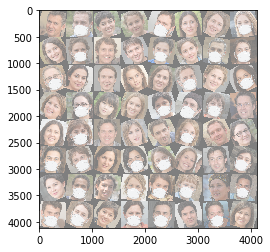

In [10]:
# Retreive images
images, labels = next(iter(train_loader))

# Display images
imshow(torchvision.utils.make_grid(images))

### Exploring an image, checking it's `dimentions`, and `label`

In [11]:
# Print first image dimentions
print(images[0].shape)

# Print first image label
print(labels[0])

torch.Size([3, 512, 512])
tensor(1)


In [12]:
# Save the session
dill.dump_session('notebook_env.db')

## Building the CNN with the `sequential` module

In [13]:
class Net(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        # Variables
        k_size = 3
        stride = 1
        padding = 1
        # Declare all the layers for feature extraction
        self.features = nn.Sequential(
            # First convolutional layers
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=k_size, stride=stride, padding=padding),
            # Max pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2),
            # ReLU nonlinearity
            nn.ReLU(inplace=True),
            # Batch Normalization
            nn.BatchNorm2d(num_features = 10),
            # Second convolutional layers
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=k_size, stride=stride, padding=padding),
            # Max pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2),
            # ReLU nonlinearity
            nn.ReLU(inplace=True),
            # Batch Normalization
            nn.BatchNorm2d(num_features = 32),
            # Third convolutional layers
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=k_size, stride=stride, padding=padding),
            # ReLU nonlinearity
            nn.ReLU(inplace=True),
            # Batch Normalization
            nn.BatchNorm2d(num_features = 64),
            # Fourth convolutional layers
            # nn.Conv2d(in_channels=64, out_channels=128, kernel_size=k_size, stride=stride, padding=padding),
            # # Max pooling layer
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # # ReLU nonlinearity
            # nn.ReLU(inplace=True),
            # # Batch Normalization
            # nn.BatchNorm2d(num_features = 128),
            # # Fith convolutional layers
            # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=k_size, stride=stride, padding=padding),
            # # Max pooling layer
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # # ReLU nonlinearity
            # nn.ReLU(inplace=True),
            # # Batch Normalization
            # nn.BatchNorm2d(num_features = 256)
        )
        # Declare all the layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(128 * 128 * 64, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 512), 
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    # Forward method
    def forward(self, x):
        # Apply the feature extractor in the input
        x = self.features(x)
        # Squeeze the three spatial dimensions in one
        x = x.view(-1, 128 * 128 * 64)
        # Classify the images
        x = self.classifier(x)
        return x




## Training the model

### Optimizer with L2-regularization and Loss Function

In [14]:
# Instantiate the network and move it to GPU
model = Net()
model.to(device)
# Instantiate the cross-entropy loss
criterion = nn.CrossEntropyLoss()

# Instantiate the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.001)

In [16]:
# Save the session
dill.dump_session('notebook_env.db')

In [17]:
for n, p in model.named_parameters():
    print(p.device, "", n)

cpu  features.0.weight
cpu  features.0.bias
cpu  features.3.weight
cpu  features.3.bias
cpu  features.4.weight
cpu  features.4.bias
cpu  features.7.weight
cpu  features.7.bias
cpu  features.8.weight
cpu  features.8.bias
cpu  features.10.weight
cpu  features.10.bias
cpu  classifier.0.weight
cpu  classifier.0.bias
cpu  classifier.2.weight
cpu  classifier.2.bias
cpu  classifier.4.weight
cpu  classifier.4.bias


In [18]:
# keeping track of losses 
train_losses = []
valid_losses = []

print("starting training.")

for epoch in range(num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0

    # Training the model
    model.train()
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and moving data to GPU
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Release GPU memory
        torch.cuda.empty_cache()

        # Compute the forward pass
        outputs = model(inputs)
        
        # Compute the loss function
        loss = criterion(outputs, labels)
        
        # Compute the gradients
        loss.backward()
    
        # Update the weights
        optimizer.step()

        # update training loss
        train_loss += loss.item() * inputs.size(0)

        print("Training in progress ...")

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    train_losses.append(train_loss)

    # print training statistics 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

print("Training completed")

.
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Epoch: 0 	Training Loss: 0.159519
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in pr

In [19]:
# Save the session after training
dill.dump_session('notebook_env.db')

In [23]:
# Release GPU memory
torch.cuda.empty_cache()

## Evaluating the model


In [24]:
correct, total = 0, 0
predictions = []

model.eval()

# Iterate over the data in the test_loader
for i, data in enumerate(val_loader, 0):
  
    # Get the image and label from data
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    
    # Make a forward pass in the net with your image
    outputs = model(images)
    
    # Argmax the results of the net
    _, predicted = torch.max(outputs.data, 1)
    predictions.append(outputs)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    # Print predictions
    if predicted == labels:
        print("Yipes, the net made the right prediction " + str(predicted))
    else:
        print("The net prediction was " + str(predicted) + ", but the correct label is: " + str(labels))

print("The testing set accuracy of the network is: %d %%" % (100 * correct / total))

rediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the 

In [ ]:

# update average validation loss 
    valid_loss += loss.item() * images.size(0)

    # calculate average losses
    valid_loss = valid_loss/len(val_loader.sampler)
    valid_losses.append(valid_loss)

    # print validation statistics 
    print('Epoch: {} \tValidation Loss: {:.6f}'.format(i, valid_loss))

In [ ]:
# Save the session with dill
dill.dump_session('notebook_env.db')

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1060'